# Autoencoder

In the [previous notebook](./rbm.ipynb), we have met restricted Boltzmann machines (RBMs) and thereby taken our first step into the realm of unsupervised learning. Now, we meet autoencoders as an alternative tool for this task.

Similar to RBMs, also autoencoders are equipped with a hidden layer that can be used to store a compressed form of the data. However, while RBMs are set up in the framework of undirected graphical models, autoencoders operate in a *feed-forward mode*. In particular, they consist of two parts: an **encoder** and a **decoder**.

The *encoder* takes high-dimensional observed data as input and compresses it into more condensed representation stored in the hidden layer. The encoder is often referred to as *recognition* or *inference network* since it infers a more concise representation of the data.

On the other hand, the task of the *decoder* is to reconstruct high-dimensional data in the observation space from the hidden latent representations. Therefore, it is known as *generative network*. 

So far we have explored the flexibility of deep neural networks for performing *supervised learning*[.](./sgd.ipynb) After many of the deep-learning methods developed in the last few years have become widespread in the industrial practice, an increasing proportion of academics are now in the process of pushing forward the frontiers of *unsupervised learning*. 

The compression paradigm of autoencoders is illustrated in the following figure from the outstanding [Keras Blog post on autoencoders](https://blog.keras.io/building-autoencoders-in-keras.html).

<img src="images/ae.jpg" alt="Drawing" style="width: 700px;"/>
https://blog.keras.io/building-autoencoders-in-keras.html

The rest of the notebook is based on [Chapter 7 of Deep Learning with Python](https://github.com/fchollet) and the [Keras Blog post on autoencoders](https://blog.keras.io/building-autoencoders-in-keras.html).

## Single-Layer Baseline 

Defining an autoencoder in `keras` is as easy as it gets. We only need to set up a sequential model consisting of two `Dense` layers.

In [9]:
from keras.layers import Input, Dense
from keras.models import Sequential

input_dim = 784
encoding_dim = 32

enc = Dense(encoding_dim, input_shape=(input_dim,), activation = 'relu')
dec = Dense(input_dim, activation = 'sigmoid')
auto_enc = Sequential(enc + dec)

auto_enc.compile(optimizer='adadelta', loss='binary_crossentropy')

### Image Reconstruction

In a first step, we train the autoencoder to reconstruct digits from the MNIST dataset. For this purpose, we normalize the MNIST data.

In [18]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()
x_train, x_test = [data.astype('float32') / 255 
                   for data in [x_train, x_test]]
x_train, x_test = [data.reshape((len(data), np.prod(data.shape[1:]))) 
                   for data in [x_train, x_test]]

On the normalized data, we train the autoencoder.

In [49]:
batch_size = 128

auto_enc.fit(x_train, x_train,
                epochs=40,
                batch_size=batch_size,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/40
60000/60000 [==============================] - 4s 62us/step - loss: 0.3543 - val_loss: 0.2726
Epoch 2/40
 3328/60000 [>.............................] - ETA: 3s - loss: 0.2724

KeyboardInterrupt: 

Now, we visualize the reconstructed images.

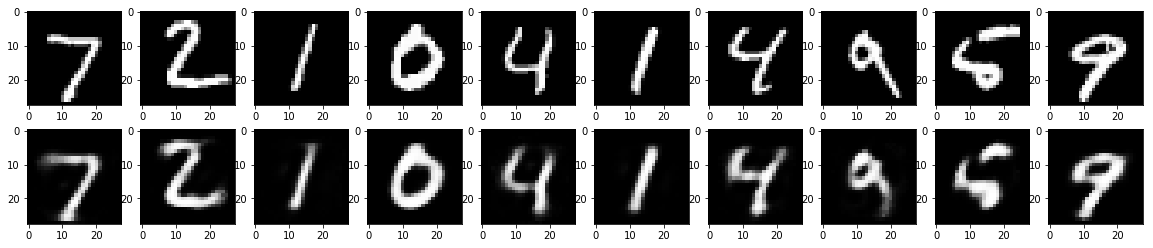

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

n = 10  # how many digits we will display
img_size = (28, 28)

plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(img_size))
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(auto_enc.predict(x_test)[i].reshape(img_size))
plt.show()

### Image Denoising

In the next step, we add noise to the digits to test if the autoencoder can still reconstruct the digits under more difficult circumstances.

In [94]:
noise_factor = 0.5
seed = 42
rand = np.random
rand.seed(seed = seed)

x_train_noisy = x_train + noise_factor * rand.normal(size=x_train.shape) 
x_test_noisy = x_test + noise_factor * rand.normal(size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

Let's visualize the noisy images and how well our present autoencoder succeeds in the reconstruction task.

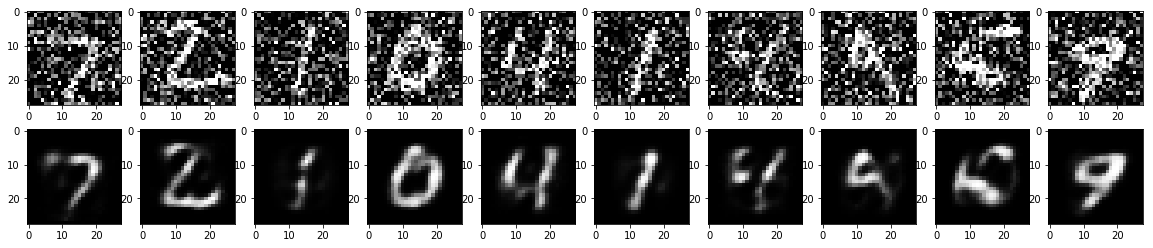

In [47]:
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(img_size))
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(auto_enc.predict(x_test_noisy)[i].reshape(img_size))
plt.show()

Now, we retrain the autoencoder with the noisy images. The resulting models are often called **Denoising autoencoders**.

In [50]:
auto_enc = Sequential([
    Dense(encoding_dim, input_shape=(input_dim,), activation = 'relu'),
    Dense(input_dim, activation = 'sigmoid')
])
auto_enc.compile(optimizer='adadelta', loss='binary_crossentropy')

auto_enc.fit(x_train_noisy, x_train,
                epochs=40,
                batch_size=batch_size,
                validation_data=(x_test_noisy, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/40
60000/60000 [==============================] - 4s 62us/step - loss: 0.3257 - val_loss: 0.2669
Epoch 2/40
60000/60000 [==============================] - 4s 61us/step - loss: 0.2650 - val_loss: 0.2616
Epoch 3/40
60000/60000 [==============================] - 3s 54us/step - loss: 0.2577 - val_loss: 0.2515
Epoch 4/40
60000/60000 [==============================] - 3s 54us/step - loss: 0.2454 - val_loss: 0.2378
Epoch 5/40
60000/60000 [==============================] - 3s 53us/step - loss: 0.2321 - val_loss: 0.2249
Epoch 6/40
60000/60000 [==============================] - 3s 55us/step - loss: 0.2202 - val_loss: 0.2137
Epoch 7/40
60000/60000 [==============================] - 3s 54us/step - loss: 0.2102 - val_loss: 0.2044
Epoch 8/40
60000/60000 [==============================] - 3s 52us/step - loss: 0.2018 - val_loss: 0.1968
Epoch 9/40
60000/60000 [==============================] - 3s 52us/step - loss: 0.1949 - val_loss: 0.1906
Epoch

Repeating the visualization after the training, we see that the quality is notably improved.

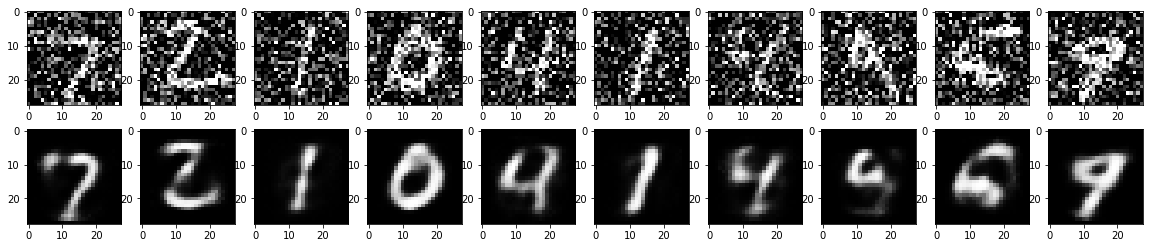

In [51]:
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(img_size))
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(auto_enc.predict(x_test_noisy)[i].reshape(img_size))
plt.show()

**Homework.** Improve the autoencoder by adding further hidden layers to the encoder and decoder.

## Convolutional Autoencoder

The single-layer autoencoder already exhibits descent image reconstruction quality. However, in order to make use of the locality of information inherent in image data, state-of-the-art autoencoders rely on convolutional architectures. We for both the encoder and the decoder a 3-layer structure suggested in https://blog.keras.io/building-autoencoders-in-keras.html.

In [86]:
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D

img_size + (1,)

enc = [Conv2D(encoding_dim, (3, 3), activation='relu', padding='same', input_shape=img_size + (1,)),
       MaxPooling2D(padding='same'),
       Conv2D(encoding_dim, (3, 3), activation='relu', padding='same'),
       MaxPooling2D(padding='same')
  ]

dec=[Conv2D(encoding_dim, (3, 3), activation='relu', padding='same'),
     UpSampling2D(),
     Conv2D(encoding_dim, (3, 3), activation='relu', padding='same'),
     UpSampling2D(),
     Conv2D(1, (3, 3), activation='sigmoid', padding='same')
]

auto_enc = Sequential(enc + dec)
auto_enc.compile(optimizer='adadelta', loss='binary_crossentropy')

We convert the MNIST-data again into their original shape and then train the convolutional autoencoder. 

In [87]:
x_train, x_test, x_train_noisy, x_test_noisy = [np.reshape(data, (len(data), 28, 28, 1))
                                               for data in [x_train, x_test, x_train_noisy, x_test_noisy]]


auto_enc.fit(x_train_noisy, x_train,
                epochs=100,
                batch_size=128,
                validation_data=(x_test_noisy, x_test)
             )

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 114s 2ms/step - loss: 0.1830 - val_loss: 0.1281
Epoch 2/100
60000/60000 [==============================] - 116s 2ms/step - loss: 0.1202 - val_loss: 0.1119
Epoch 3/100
60000/60000 [==============================] - 117s 2ms/step - loss: 0.1124 - val_loss: 0.1075
Epoch 4/100
60000/60000 [==============================] - 112s 2ms/step - loss: 0.1086 - val_loss: 0.1063
Epoch 5/100
60000/60000 [==============================] - 121s 2ms/step - loss: 0.1059 - val_loss: 0.1046
Epoch 6/100
60000/60000 [==============================] - 114s 2ms/step - loss: 0.1045 - val_loss: 0.1027
Epoch 7/100
60000/60000 [==============================] - 112s 2ms/step - loss: 0.1033 - val_loss: 0.1023
Epoch 8/100
60000/60000 [==============================] - 113s 2ms/step - loss: 0.1025 - val_loss: 0.1010
Epoch 9/100
60000/60000 [==============================] - 117s 2ms/step - loss: 0.1016 - val_

The visualization confirms that the convolutional architecture provides a superior reconstruction quality.

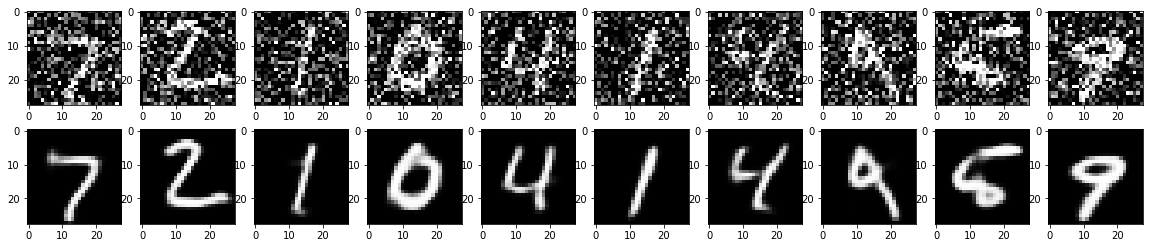

In [95]:
plt.figure(figsize=(20, 4))
preds = auto_enc.predict(x_test_noisy)
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(img_size))
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(preds[i].reshape(img_size))
plt.show()

## Variational Autoencoder

A disadvantage of the autoencoders described above is that the training process only provides a weak towards learning a useful latent space representation. The reason is that only those parts of the latent space that are close to the image of a noisy digit are encouraged to produce a useful high-dimensional representation. 

This can be illustrated by increasing the noise level of the test data. If we plug in white noise, then they become reconstructed as mysterious glyphs. 

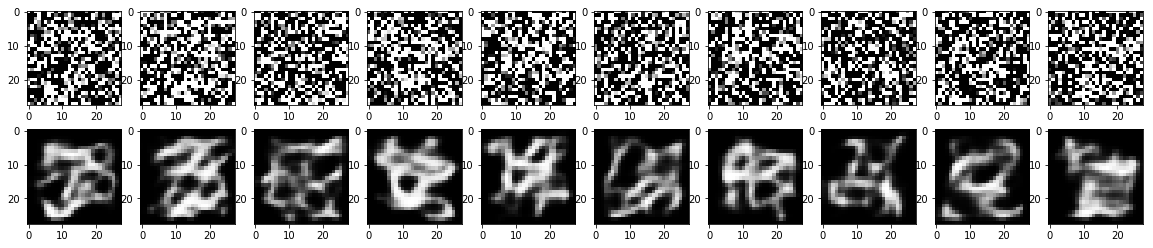

In [97]:
noise_factor = 2.0
seed = 42
rand.seed(seed = seed)
x_test_noisy = x_test + noise_factor * rand.normal(size=x_test.shape) 
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

plt.figure(figsize=(20, 4))
preds = auto_enc.predict(x_test_noisy)
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(img_size))
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(preds[i].reshape(img_size))
plt.show()

**Variational Autoencoders (VAE)** introduced by [D. Kingma and M. Welling](https://openreview.net/forum?id=33X9fd2-9FyZd) avoid this problem by mapping a high-dimensional observed data point to the *paramaters of a distribution* on the latent space, rather than to a single point. A similar approach is taken by [D. J. Rezende, S. Mohamed, D. Wierstra](http://proceedings.mlr.press/v32/rezende14.html). Moreover, VAEs are trained using an objective that encourages this distribution not to move too far away from a simple prior distribution. These changes encourage a latent representation that is far more representative to the original distribution than it is the case for the deterministic autoencoders.

### Variational Inference and the Evidence Lower Bound

The guiding principle behind the VAE is **variational inference**. Suppose, we have a candidate parametric dense $p(x) = p_\theta(x)$ for describing the data and we want to optimize the parameters $\theta$ via maximum likelihood. Suppose that the distribution is constructed with the help of latent variables $z$ in the sense that
$$p(x) = \int p(x|z) p(z) {\rm d}z$$
In particular, if q(z) is any probability density on the latent space, then Jensen's inequality gives that
\begin{align*}
\log \int  p(z) \frac{p(x|z)}{q(z)}q(z) {\rm d}z &\ge  \int\log  \Big( p(z) \frac{p(x|z)}{q(z)}\Big)q(z) {\rm d}z 
= \mathbb{E}_q[p(x|z)] - KL(q|p),
\end{align*}
where $KL(q|p) = \mathbb{E}_q [\frac{q(z)}{p(z)}]$ denotes the **Kullback-Leibler distance** between $q$ and $p$. The right-hand side is often called **evidence lower bound (ELBO)**. Instead of optimizing $p(x)$, in variational inference we use the ELBO as a surrogate objective. As we will see, the maximization of the ELBO is often feasible.

The first contribution on the right-hand side is called **reconstruction term**. It is a substitute for the reconstruction objective in the classical autoencoder. Indeed, it incentives latent representations which assign high likelihood to the originating observed data point $x$.

The Kullback-Leibler distance serves as a **regularization term**. It discourages an overly complicated approximate posterior $q(z|x)$, thereby ensuring it has good generalization properties. This regularization contribution is missing in the classical autoencoders and therefore leads to the dissatisfactory latent representation described above.

Although the ELBO is only a surrogoate objective, it still provides us with a metric for deciding when to stop the training process and to assess the quality of the model fit.

If $q(z) = p(z|x)$, then the ELBO is an actually an equality. Then, the optimization task essentially reduces to the **expectation-maximization** algorithm. However, the computation of the latent distribution $p(z|x)$ is often intractable, so that we have to approximate $p(z|x)$ by more tractable parametric **approximate posterior $q_{\phi(x)}(z)$**. 

**Homework** Show that if is $p(z) p(x|z)/q(z)$ is constant in $z$, then $q(z) = p(z|x)$.

### Reparametrization Trick

In order to maximize the ELBO with respect to the parameters $\theta$ of $p_\theta$ and $\phi(x)$ of $q_{\phi(x)}$ would like to resort to [stochastic gradient descent](./sgd.ipynb). Typically, $p_\theta(x|z)$ is a neural network with input $z$ and parameters $\theta$, so that computing gradients with respect to $\theta$ is not an issue. 

On the other hand, computing gradients with respect to $\phi(x)$ is not entirely obvious, since the density $q$ is also used to draw samples in the ELBO. Here, the **reparametrization trick** proposed by [D. Kingma and M. Welling](https://openreview.net/forum?id=33X9fd2-9FyZd) enters the stage. We explain this trick for the example when $q$ is Gaussian.

Typically, we assume that the mean $\mu(x)$ and diagonal covariance $\Sigma(x)$ of $q_{\phi(x)}(z) \sim \mathcal{N}(z; \mu_\varphi(x), \Sigma_\varphi(x))$ are nonlinear functions of the data point $x$. More precisely, $(\mu(x), \Sigma(x)) = g_\varphi(x)$, where $g_\varphi$ is a neural network with  weights $\varphi$. Then, samples from $q_{\phi(x)}$ can be obtained as $z = \mu(x) + \varepsilon \sigma(x)$, where $\varepsilon \sim \mathcal{N}(0; I_n)$ follows a standard normal distribution. 

This reparametrization has the advantage that the ELBO can up to constants be rewritten as
$$\mathbb{E}_{\varepsilon \sim \mathcal{N}(0; I_n)}[\log p_\theta(x| \mu_\varphi(x) + \varepsilon \sigma_\varphi(x))] - \mathbb{E}_{\varepsilon \sim \mathcal{N}(0; I_n)}\Big[\log\Big(\frac{({\rm det}(\Sigma_\varphi(x)))^{-1/2}\mathcal{N}_{}(\varepsilon;0, I_n )}{p(\mu_\varphi(x) + \varepsilon \sigma_\varphi(x)))}\Big)\Big]$$

Now, both the weights of the inference and of the generative network appear inside the expectation, so that the ELBO becomes amenable to optimization via gradient descent.

### Example: Digit Generation

As an example, we discuss the generation of MNIST digits as presented in https://blog.keras.io/building-autoencoders-in-keras.html. First, we define an auxiliary sampling function to perform the reparametrization trick.

In [23]:
from keras import backend as K

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(latent_dim,))
    return z_mean + K.exp(z_log_var) * epsilon

### Recognition Network

In the recognition network the mean and log-variance are parametrized by a single-layer dense network. 

In [24]:
from keras.layers import Input, Dense

original_dim = 28 * 28
intermediate_dim = 512

inp= Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(inp)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

To define the encoder, we introduce a *Lambda*-layer, which samples a Gaussian with the given mean and variance

In [34]:
from keras.layers import Lambda
from keras.models import Model

latent_dim = 2

z = Lambda(sampling)([z_mean, z_log_var])
encoder = Model(inp, z)

### Generative Network

Also the decoder is simply a MLP with a single hidden layer.

In [36]:
from keras.models import Sequential

latent_inputs = Input(shape=(latent_dim,))
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

decoder = Model(latent_inputs, outputs)

### Autoencoder

The autoencoder is now just the concatenation of the encoder and the decoder.

In [37]:
outputs = decoder(encoder(inp))
vae = Model(inp, outputs)

### Loss Function

Before we can start the training of the autoencoder, we need to implement the loss function derived from the ELBO. We start by analyzing the reconstruction term
$$\mathbb{E}_{z \sim \mathcal{N}(\mu(x), \Sigma(x))}[\log p_\theta(x| z)] \approx \sum_i \log p_\theta(x^{(i)}| z^{(i)}),$$
where the $\{x^{(i)}\}_i$ form a mini-batch and $z^{(i)} \sim \mathcal{N}( \mu(x^{(i)}), \Sigma(x^{(i)}))$. Conditioned on the input $z^{(i)}$, the probability $p_\theta(x^{(i)}|z^{(i)})$ is simply a product of Bernoulli probabilities, so tha the reconstruction term is simply the negative cross-entropy loss.

In [38]:
from keras.losses import binary_crossentropy

reconstruction_loss =  binary_crossentropy(inp, outputs)
reconstruction_loss *= original_dim

It remains to deal with the Kullback-Leibler distance

$$\mathbb{E}_{\varepsilon \sim \mathcal{N}(0; I_n)}\Big[\log\Big(\frac{({\rm det}(\Sigma_\varphi(x)))^{-1/2}\mathcal{N}_{}(\varepsilon;0, I_n )}{p(\mu_\varphi(x) + \varepsilon \sigma_\varphi(x)))}\Big)\Big]$$

If the prior $p(z)$ is also assumed to be standard Gaussian, then above Kullback-Leibler distance becomes up to constants
$$-\tfrac12\sum_i \sum_{j \le n}\log(\sigma_j^2(x)) - (\mu_j^{(i)})^2 - (\sigma_j^{(i)})^2$$
**Homework** Prove this formula!

In [39]:
kl_loss = z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

Combining the two reconstruction and regularization term, we obtain the ELBO loss.

In [44]:
vae.add_loss( K.mean(reconstruction_loss + kl_loss))
vae.compile(optimizer='adam')

/home/christian/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Output "model_5" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "model_5" during training.
  


### Training

Now, we load the MNIST data...

In [46]:
import numpy as np
from keras.datasets import mnist

# MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

... and start training.

In [47]:
epochs = 50
batch_size = 100

vae.fit(x_train,
                epochs=epochs,
                batch_size=batch_size,
validation_data=(x_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 19s 317us/step - loss: 758.9513 - val_loss: 681.6801
Epoch 2/50
60000/60000 [==============================] - 19s 316us/step - loss: 671.1238 - val_loss: 663.5911
Epoch 3/50
60000/60000 [==============================] - 18s 294us/step - loss: 658.3866 - val_loss: 653.1056
Epoch 4/50
60000/60000 [==============================] - 17s 289us/step - loss: 647.0073 - val_loss: 647.6872
Epoch 5/50
60000/60000 [==============================] - 17s 288us/step - loss: 636.7479 - val_loss: 633.4343
Epoch 6/50
60000/60000 [==============================] - 17s 286us/step - loss: 628.7644 - val_loss: 626.2915
Epoch 7/50
60000/60000 [==============================] - 17s 277us/step - loss: 622.7439 - val_loss: 623.4455
Epoch 8/50
60000/60000 [==============================] - 18s 301us/step - loss: 617.7454 - val_loss: 618.3736
Epoch 9/50
60000/60000 [==============================] - 17s 

If we now consider the distribution in the latent space, so sehen 

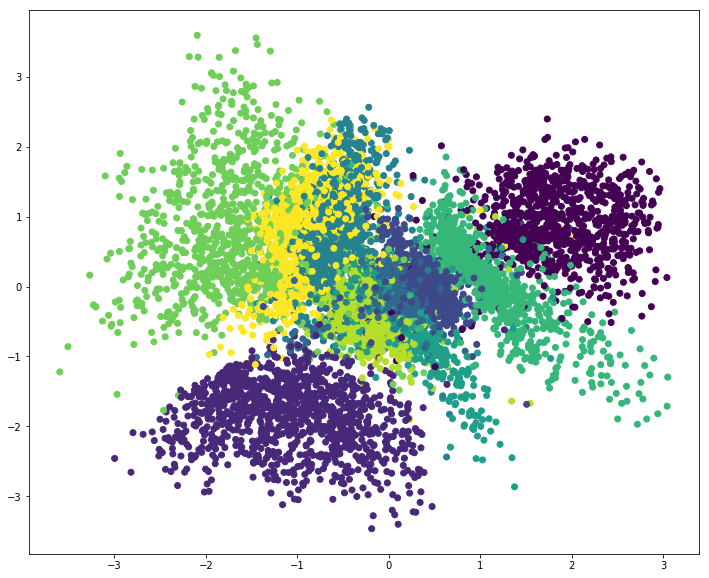

In [54]:
import matplotlib.pyplot as plt
%matplotlib inline

sample_size = 10000
z = encoder.predict(x_test[:sample_size,:])

plt.figure(figsize=(12, 10))
plt.scatter(z[:, 0], z[:, 1], c=y_test[:sample_size])
plt.show()

We can also sample points from the two-dimensional latent space and convert them into digits.

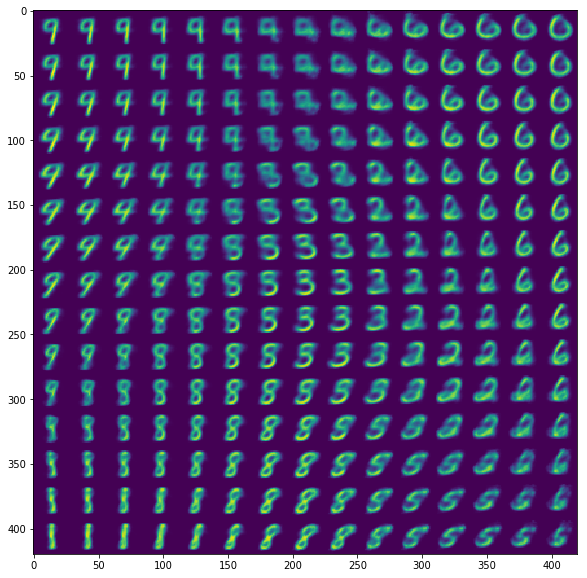

In [78]:
n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = np.linspace(-1, 1, n)
grid_y = np.linspace(-1, 1, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

## CelebA

Next, train a VAE for the CelebA dataset.